In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    LayerNormalization,
    MultiHeadAttention,
    Layer,
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
# Load the dataset
data = pd.read_csv("worldometer_coronavirus_daily_data.csv")

# Filter for the country of interest (India in this case)
india_data = data[data["country"] == "India"].copy()

# Convert 'date' to datetime format
india_data["date"] = pd.to_datetime(india_data["date"])

# Sort the data by date to ensure the time sequence is correct
india_data.sort_values("date", inplace=True)

# Check for missing values
print(india_data.isna().sum())

# Fill or drop missing values (depending on how you want to handle them)
# For now, we can fill missing values with the last available value (forward fill)
india_data.fillna(method="ffill", inplace=True)

# Confirm that missing values are handled
print(india_data.isna().sum())


date                       0
country                    0
cumulative_total_cases     0
daily_new_cases            1
active_cases               0
cumulative_total_deaths    0
daily_new_deaths           5
dtype: int64
date                       0
country                    0
cumulative_total_cases     0
daily_new_cases            1
active_cases               0
cumulative_total_deaths    0
daily_new_deaths           5
dtype: int64


In [3]:
# Create lag features for the past 3 days of cumulative_total_cases
for lag in range(1, 4):
    india_data[f"lag_{lag}"] = india_data["cumulative_total_cases"].shift(lag)

# Drop rows with NaN values introduced by lagging
india_data.dropna(inplace=True)


In [4]:
# Select features and target
features = [
    "daily_new_cases",
    "active_cases",
    "cumulative_total_deaths",
    "daily_new_deaths",
] + [f"lag_{lag}" for lag in range(1, 4)]
target = "cumulative_total_cases"

X = india_data[features]
y = india_data[target]

# Check the shapes of X and y
print(X.shape, y.shape)


(815, 7) (815,)


In [5]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the feature matrix and target variable
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1, 1))

# Convert back to DataFrame for easy inspection (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print(X_scaled_df.head())


   daily_new_cases  active_cases  cumulative_total_deaths  daily_new_deaths  \
0              0.0           0.0                      0.0               0.0   
1              0.0           0.0                      0.0               0.0   
2              0.0           0.0                      0.0               0.0   
3              0.0           0.0                      0.0               0.0   
4              0.0           0.0                      0.0               0.0   

   lag_1  lag_2  lag_3  
0    0.0    0.0    0.0  
1    0.0    0.0    0.0  
2    0.0    0.0    0.0  
3    0.0    0.0    0.0  
4    0.0    0.0    0.0  


In [6]:
# Function to create sequences
def create_sequences(X, y, time_step):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i : (i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)


# Set time step (e.g., 60 for a 60-day window)
time_step = 30

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)

# Check the shape of the resulting sequences
print(X_seq.shape, y_seq.shape)  # Expecting (samples, time_steps, features)


(785, 30, 7) (785, 1)


In [7]:
# Split the data into training and testing sets
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (628, 30, 7), (628, 1)
Testing data shape: (157, 30, 7), (157, 1)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Layer,
    Dense,
    Dropout,
    LayerNormalization,
    Input,
    MultiHeadAttention,
)
from tensorflow.keras.models import Model
import numpy as np

# Positional Encoding Layer
class PositionalEncoding(Layer):
    def __init__(self, sequence_len, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(
            **kwargs
        )  # Accept extra args like `trainable` and `dtype`
        self.sequence_len = sequence_len
        self.d_model = d_model
        self.pos_encoding = self.get_positional_encoding(sequence_len, d_model)

    def get_positional_encoding(self, sequence_len, d_model):
        positions = np.arange(sequence_len)[:, np.newaxis]
        dims = np.arange(d_model)[np.newaxis, :]

        angle_rates = 1 / np.power(10000, (2 * (dims // 2)) / np.float32(d_model))
        angle_rads = positions * angle_rates

        # Apply sin to even indices and cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "sequence_len": self.sequence_len,
                "d_model": self.d_model,
            }
        )
        return config

In [9]:
from tensorflow.keras.regularizers import l2


# Transformer Encoder Block with L2 regularization
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, l2_value=0):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(
        inputs, inputs
    )
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feedforward Network with L2 regularization
    x = Dense(ff_dim, activation="relu", kernel_regularizer=l2(l2_value))(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x


In [10]:
# Build the Transformer model
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    l2_value=0,
):
    inputs = Input(shape=input_shape)

    # Add positional encoding
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)

    # Add Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_value)

    # Global average pooling over the time dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Dense layers for the final prediction
    x = Dense(mlp_units, activation="relu", kernel_regularizer=l2(l2_value))(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1)(x)

    # Create the model
    return Model(inputs, outputs)


# Model parameters
input_shape = (X_train.shape[1], X_train.shape[2])  # Shape: (60, 7)
head_size = 256  # Size of the attention head
num_heads = 4  # Number of attention heads
ff_dim = 256  # Feedforward network hidden dimension
num_transformer_blocks = 2  # Number of Transformer blocks
mlp_units = 128  # Number of units in the dense layer
dropout = 0.2  # Dropout rate

# Build the model
transformer_model = build_transformer_model(
    input_shape=input_shape,
    head_size=128,
    num_heads=2,
    ff_dim=128,
    num_transformer_blocks=1,
    mlp_units=64,
    dropout=0.2,
    l2_value=1e-4,  # Add L2 regularization
)

# Compile the model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
transformer_model.compile(optimizer="adam", loss="mean_squared_error")

# Print the model summary
transformer_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 30, 7)     │          0 │ input_layer[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 7)     │      7,943 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 7)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 7)     │         14 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 128)   │      1,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,558 (68.59 KB)

 Trainable params: 17,558 (68.59 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Train the model with early stopping
history = transformer_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.0079
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - val_loss: 0.0060
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028 - val_loss: 0.0091
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030 - val_loss: 0.0065
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0032 - val_loss: 0.0087
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0029 - val_loss: 0.0160
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

In [54]:
# Make predictions on training and testing data
train_predictions = transformer_model.predict(X_train)
test_predictions = transformer_model.predict(X_test)

# Inverse scale the predictions and actual values
train_predictions = scaler_y.inverse_transform(train_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)
y_train_actual = scaler_y.inverse_transform(y_train)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))

# Calculate R² score for training and testing data
train_r2 = r2_score(y_train_actual, train_predictions)
test_r2 = r2_score(y_test_actual, test_predictions)

# Print the evaluation metrics
print(f"Transformer Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
print(f"Transformer Train R²: {train_r2}, Test R²: {test_r2}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Transformer Train RMSE: 3204057.289043272, Test RMSE: 2938928.2166670584
Transformer Train R²: 0.938021953054653, Test R²: 0.22722395597125722


In [24]:
# save the model
# transformer_model.save("transformer_model_optimized_(test1).keras

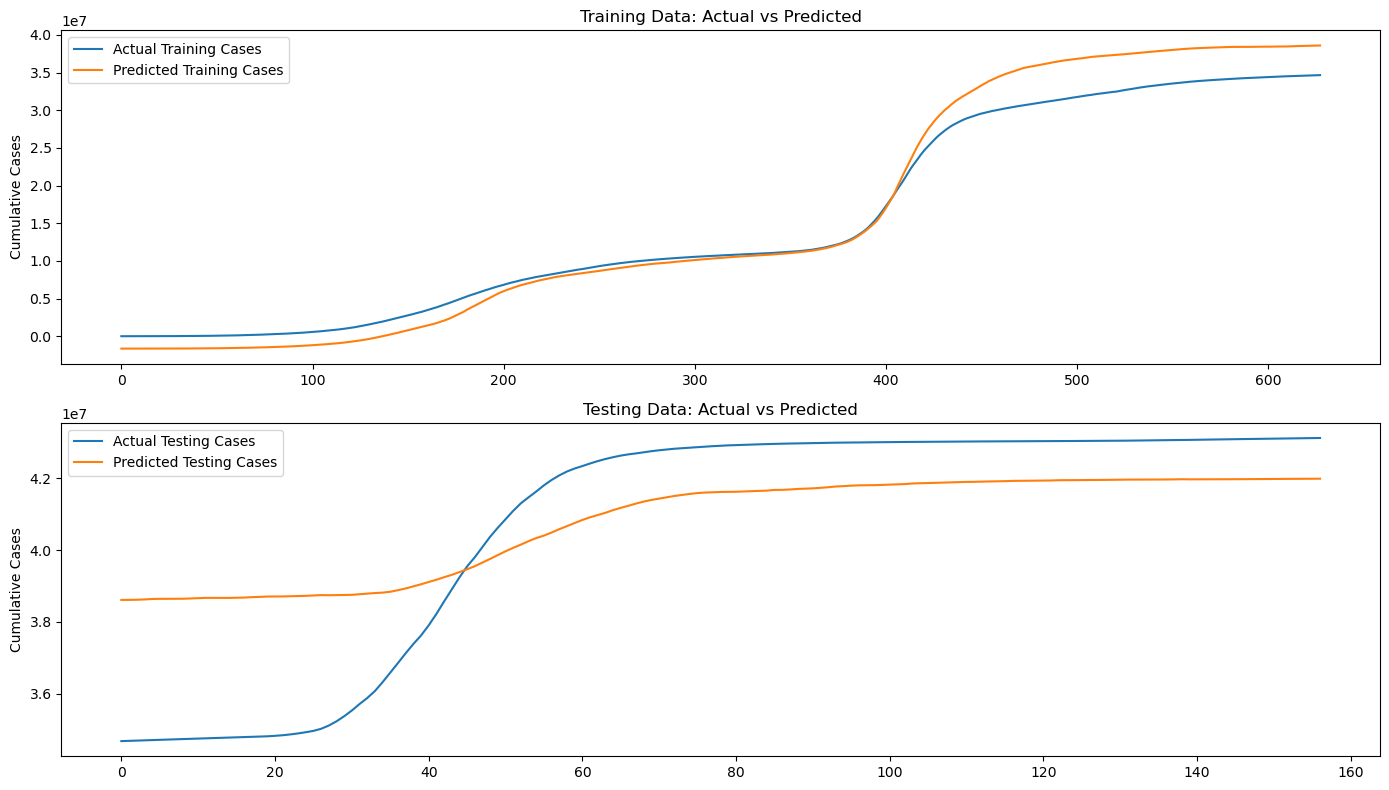

In [25]:
# Plot the actual vs predicted cumulative cases
plt.figure(figsize=(14, 8))

# Training Data Plot
plt.subplot(2, 1, 1)
plt.plot(y_train_actual, label="Actual Training Cases")
plt.plot(train_predictions, label="Predicted Training Cases")
plt.title("Training Data: Actual vs Predicted")
plt.ylabel("Cumulative Cases")
plt.legend()

# Testing Data Plot
plt.subplot(2, 1, 2)
plt.plot(y_test_actual, label="Actual Testing Cases")
plt.plot(test_predictions, label="Predicted Testing Cases")
plt.title("Testing Data: Actual vs Predicted")
plt.ylabel("Cumulative Cases")
plt.legend()

plt.tight_layout()
plt.show()


c:\Users\emada\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


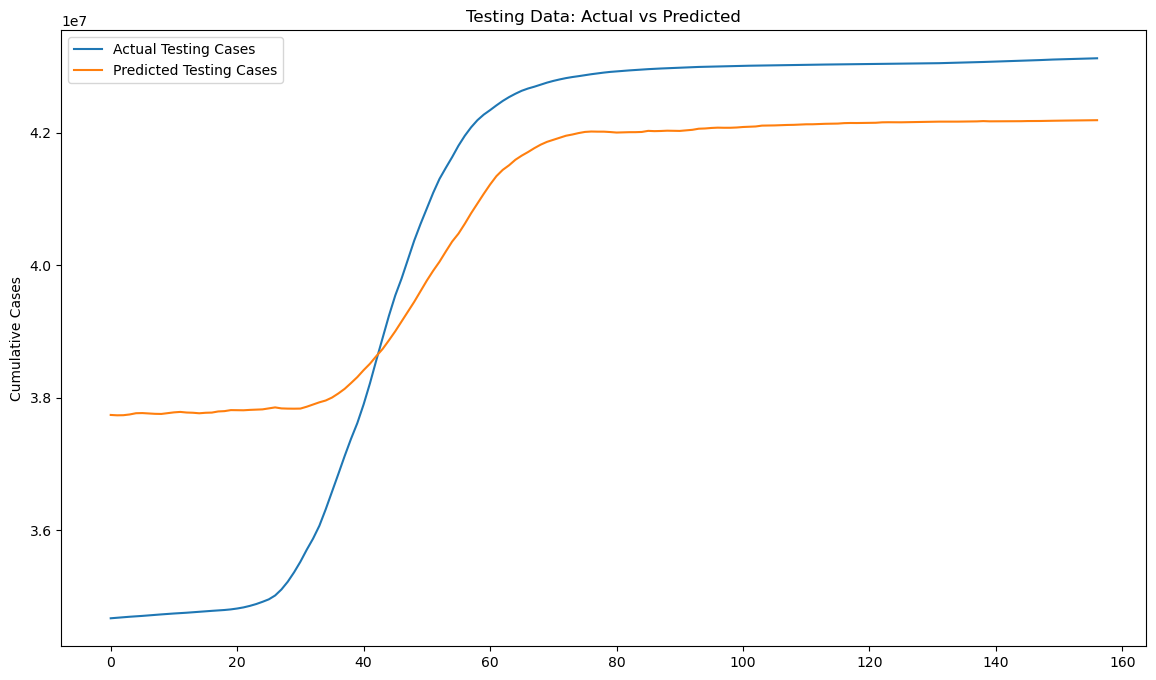

In [62]:
from tensorflow.keras.models import load_model

b2 = load_model(
    "transformer_model_optimized.keras",
    custom_objects={"PositionalEncoding": PositionalEncoding},
)

# Make predictions on training and testing data
train_predictions = b2.predict(X_train)
test_predictions = b2.predict(X_test)

p=scaler_y.inverse_transform(test_predictions)
y=scaler_y.inverse_transform(y_test)

# plot
plt.figure(figsize=(14, 8))
plt.plot(y, label="Actual Testing Cases")
plt.plot(p, label="Predicted Testing Cases")
plt.title("Testing Data: Actual vs Predicted")
plt.ylabel("Cumulative Cases")
plt.legend()
plt.show()


In [144]:
from tensorflow.keras.models import load_model

# Load the model with the custom layer
best_model = load_model(
    "transformer_model_optimized.h5",
    custom_objects={"PositionalEncoding": PositionalEncoding},
)

# Use it for predictions
predictions = best_model.predict(X_test)
# predictions = scaler_y.inverse_transform(predictions)
# y_test_actual = scaler_y.inverse_transform(y_test)

# # Calculate RMSE and R² score
# rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
# r2 = r2_score(y_test_actual, predictions)

# # Print the evaluation metrics
# print(f"Best Model RMSE: {rmse}")
# print(f"Best Model R²: {r2}")

# # Plot the actual vs predicted cumulative cases
# plt.figure(figsize=(14, 7))
# plt.plot(y_test_actual, label="Actual Cases")
# plt.plot(predictions, label="Predicted Cases")
# plt.title("Actual vs Predicted Cumulative Cases")
# plt.ylabel("Cumulative Cases")
# plt.legend()
# plt.show()




5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [145]:
# Save the model
transformer_model.save("best_transformer_model_fixed.h5")

# Load the model with the custom layer
best_model = load_model(
    "best_transformer_model_fixed.h5",
    custom_objects={"PositionalEncoding": PositionalEncoding},
)

# Use it for predictions
predictions = best_model.predict(X_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/stepWARNING:tensorflow:5 out of the last 166 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002185310FB00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


NameError: name 'predictions' is not defined

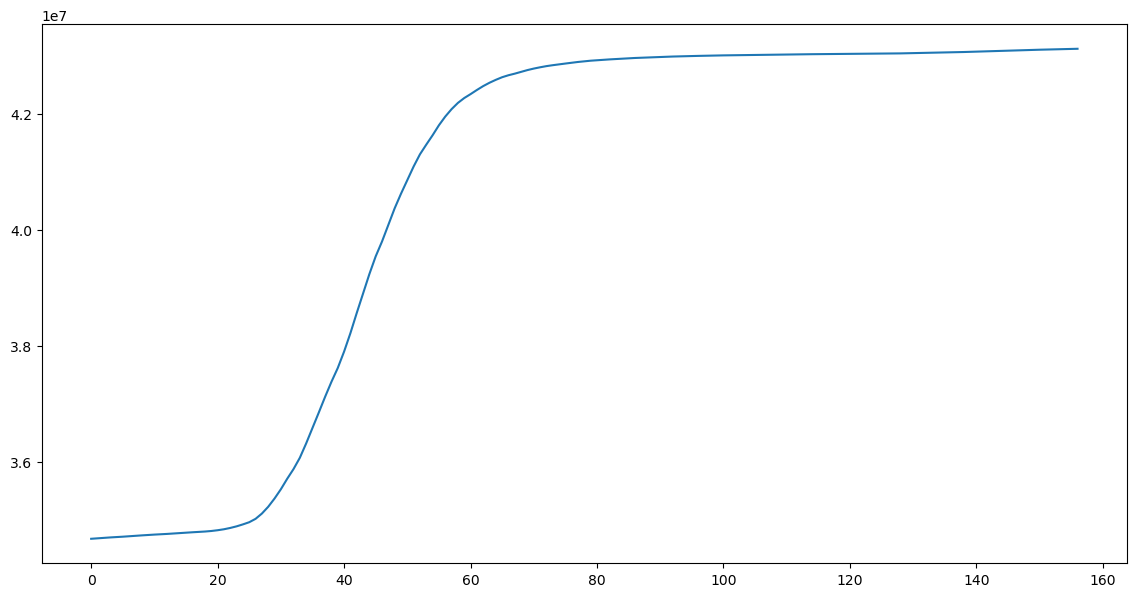

In [28]:
from tensorflow.keras.models import load_model
b1=load_model("transformer_model_optimized_(test1).keras",custom_objects={"PositionalEncoding": PositionalEncoding})
predictions1 = b1.predict(X_test)

# Plot the actual vs predicted cumulative cases
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label="Actual Cases")
plt.plot(predictions, label="Predicted Cases")
plt.plot(predictions1, label="Predicted Cases1")
plt.title("Actual vs Predicted Cumulative Cases")
plt.ylabel("Cumulative Cases")
plt.legend()
plt.show()
